# Capstone Machine Learning Algorithm Creation

In [2]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt

In [3]:
database = "group3-DB"
table = "dbo.hstock"
user = "group3_user"
password  = "K-qC4SoI_oUvepg"
server = "gen10-data-fundamentals-21-11-sql-server.database.windows.net"

Load in table from SQL using variables above

In [4]:
#read table data into a spark dataframe
conn = pymssql.connect(server, user, password, database)
cursor = conn.cursor()
query = f"SELECT * FROM {table}"
hst_df = pd.read_sql(query, conn)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Dataframe sorting

In [5]:
apple_df = hst_df[hst_df['Ticker'] == 'AAPL']
apple_df = apple_df.drop(columns = 'Ticker')
apple_df['Date'] = pd.to_datetime(apple_df['Date'], format='%Y-%m-%d')
apple_df.sort_values('Date', inplace=True)
apple_df = apple_df[apple_df['Date'] >= '2021-01-01']
apple_df.reset_index(drop=True, inplace=True)
apple_df

,Date,Open,High,Low,Close,Volume
0,2021-01-04,133.52,133.6116,126.760,129.41,143301887
1,2021-01-05,128.89,131.7400,128.430,131.01,97664898
2,2021-01-06,127.72,131.0499,126.382,126.60,155087970
3,2021-01-07,128.36,131.6300,127.860,130.92,109578157
4,2021-01-08,132.43,132.6300,130.230,132.05,105158245
...,...,...,...,...,...,...
276,2022-02-07,172.86,173.9458,170.950,171.66,77251204
277,2022-02-08,171.73,175.3500,171.430,174.83,74829217
278,2022-02-09,176.05,176.6500,174.900,176.28,71285038
279,2022-02-10,174.14,175.4800,171.550,172.12,90865899


### AR Model Stuff

Create an autoregressive model which uses the High price of Apple stock

In [6]:
m_df = apple_df.drop(columns=['Date', 'Open', 'Close', 'Low', 'Volume'])

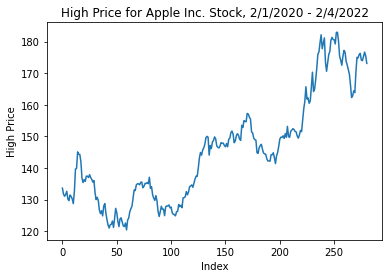

In [8]:
plt.plot(m_df['High'])

plt.ylabel('High Price')
plt.xlabel('Index')
plt.title('High Price for Apple Inc. Stock, 2/1/2020 - 2/4/2022')
plt.show()

Training/Test Split

In [31]:
ar_test_data = m_df.iloc[-15:]
ar_train_data = m_df.iloc[:-15]

ADFuller test - tells us what difference level to use

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(m_df['High'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -0.7435691142374475,
 'pvalue': 0.8351391742777452,
 'usedlag': 1,
 'nobs': 279,
 'criticalvalues': {'1%': -3.4540076534999957,
  '5%': -2.8719557347997178,
  '10%': -2.5723200648758366},
 'icbest': 1117.3359558593318}

The pvalue for this test indicates that we may need to take the difference of subsequent values in order to effectively locate the correct lag value(s)

In [13]:
m_df['Diff'] = m_df['High'] - m_df['High'].shift(1)

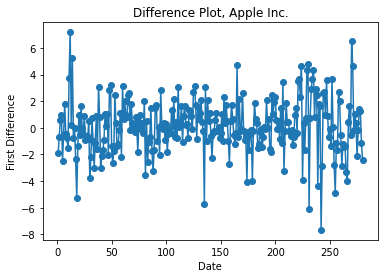

In [14]:
plt.plot(m_df['Diff'], marker='o')

plt.ylabel('First Difference')
plt.xlabel('Date')
plt.title('Difference Plot, Apple Inc.')
plt.show()

In [15]:
result = adfuller(m_df['Diff'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -14.58778610669558,
 'pvalue': 4.363550532794364e-27,
 'usedlag': 0,
 'nobs': 279,
 'criticalvalues': {'1%': -3.4540076534999957,
  '5%': -2.8719557347997178,
  '10%': -2.5723200648758366},
 'icbest': 1110.9389651281479}

By these results, we know we should use the difference to find the lag value (pvalue < 0.05)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


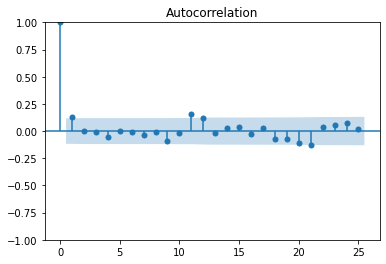

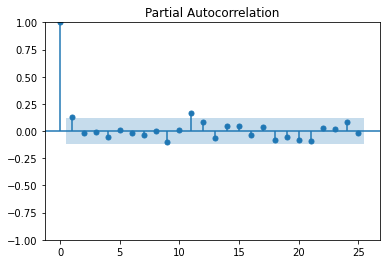

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(m_df['Diff'].dropna())
fig2=plot_pacf(m_df['Diff'].dropna())

I tested a number of different values for the lag hyperparameter and did not get significantly different results on predictions

In [32]:
# seems lag should be 1 - test various values?
from statsmodels.tsa.ar_model import AutoReg as ar
res = ar(endog = ar_train_data['High'], lags = 10).fit()
# tested various values of lag (1, 3, 5, 10) - no significant accuracy change between values

Some of the values I tried were 1, 3, 5 and 10, all of which were contained in the ACF plot given above.

In [33]:
new_dates=[m_df.index[-1]+x for x in range(1, 21)]
df_pred=pd.DataFrame(index=new_dates,columns =m_df.columns)

In [34]:
ar_df = pd.concat([m_df, df_pred])

This bit of code below creates our testing predictions

In [35]:
# start at the end of original data, go til the end of this new dataframe
ar_df['predictions']=res.predict(start=ar_train_data.shape[0], end=ar_df.shape[0])

The results of the plot show a reasonable close prediction for the next few days, but all the algorithm is doing is creating a flat line as its predictions

<AxesSubplot:>

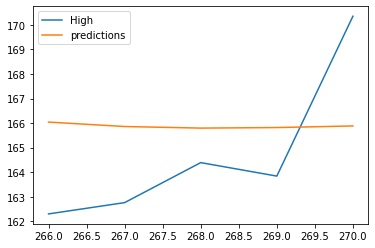

In [36]:
# High contrast plot of price versus predictions for future highs
plot_df = ar_df.iloc[ar_train_data.shape[0]:ar_train_data.shape[0]+5]
plot_df[['High', 'predictions']].plot(marker='o')

Very off - not sure what is causing this?

In [18]:
# export model for dashboard
from joblib import dump
dump(res, 'stautoreg.model')

['autoreg.model']

### ARIMA Model Creation

It appears from autocorrelation and part. autocorrelation plots that the values for p and q should be 1. d should also be 1 since we took the first difference to uncover the p and q values.

Using auto_arima function, we can find ARIMA model that minimizes AIC, a criteria for information loss

In [84]:
from pmdarima import auto_arima
auto_fit = auto_arima(ar_train_data['High'], max_p = 10, d = 1, trace=True, suppress_warnings=True, stepwise=False, max_order=15)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1193.770, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1191.187, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1193.181, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1195.176, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1196.370, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1198.319, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1191.217, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1193.181, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1195.181, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1197.180, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1198.297, Time=0.25 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=1200.273, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1193.178, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1195.180, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,1,3)(0

By these results, it recommends an ARIMA model with p = 0, d = 1 and q = 1, but the AIC results for all of these models are relatively close. As you will see from the plot below, they all gave poor model results

In [42]:
from statsmodels.tsa.arima.model import ARIMA
arima_mdl = ARIMA(endog=ar_train_data['High'], order=(4, 1, 1)).fit()
# Tried orders:
# (0, 1, 1) - best model as suggested by auto_arima function
# (10, 1, 1) - worked before training/testing split
# (5, 1, 4) - just experimenting to see if different values would cause *any* change at all
# no noticable change in any variation

Give summary of best fit model

In [24]:
arima_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                  251
Model:                ARIMA(10, 1, 1)   Log Likelihood                -521.842
Date:                Mon, 14 Feb 2022   AIC                           1067.685
Time:                        08:50:15   BIC                           1109.942
Sample:                             0   HQIC                          1084.692
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7765      0.269      2.884      0.004       0.249       1.304
ar.L2         -0.0651      0.081     -0.803      0.422      -0.224       0.094
ar.L3          0.0068      0.079      0.086      0.932      -0.148       0.161
ar.L4         -0.0255      0.075     -0.339      0.734      -0.173       0.122
ar.L5          0.0495      0.074      0.665      0.506      -0.096       0.195
ar.L6         -0.0398      0.072     -0.555      0.579      -0.181       0.101
ar.L7         -0.0088      0.076     -0.115      0.908      -0.158       0.141
ar.L8          0.0356      0.086      0.412      0.681      -0.134       0.205
ar.L9         -0.0998      0.089     -1.125      0.260      -0.274       0.074
ar.L10         0.1568      0.083      1.884      0.060      -0.006       0.320
ma.L1         -0.6924      0.268     -2.580      0.010      -1.218      -0.166
sigma2         3.8024      0.308     12.362      0.000       3.200       4.405
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                31.12
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.24
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Diagnostic Plots of Model

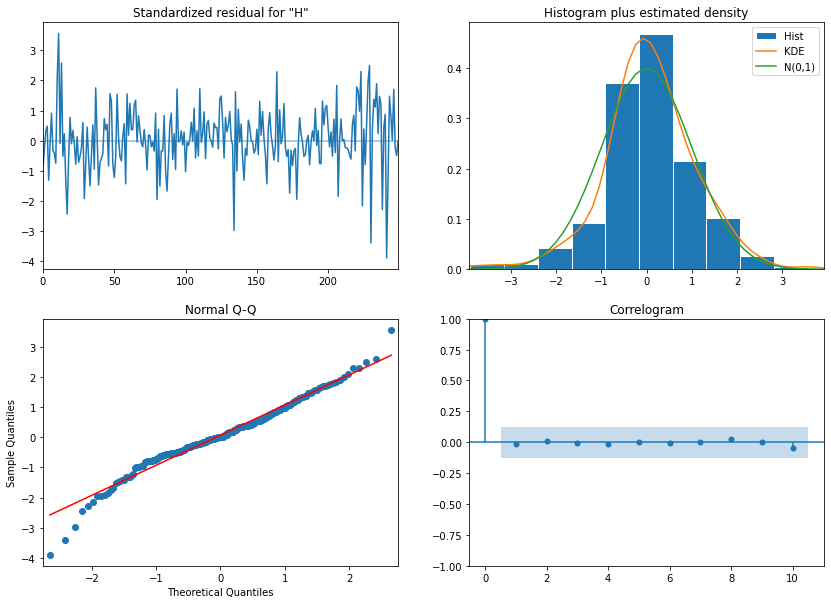

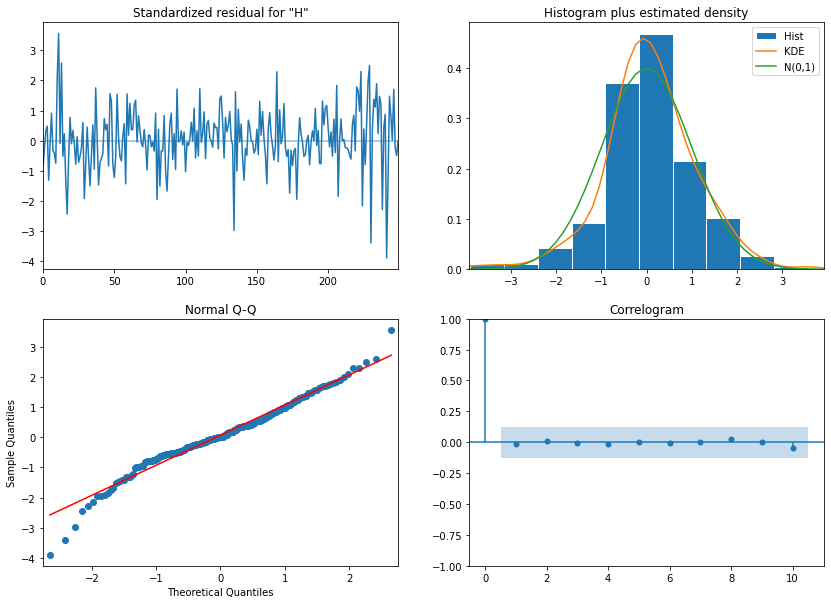

In [25]:
arima_mdl.plot_diagnostics(figsize = (14, 10))

In [43]:
new_dates=[m_df.index[-1]+x for x in range(1, 21)]
df_pred=pd.DataFrame(index=new_dates,columns=m_df.columns)
arima_df = pd.concat([m_df, df_pred])
arima_df['predictions']=arima_mdl.predict(start=ar_train_data.shape[0], end=arima_df.shape[0])

Predictions were similarly poor to the simple AR model

<AxesSubplot:>

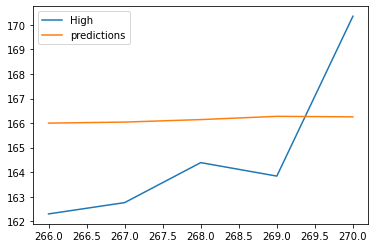

In [44]:
plot_df = arima_df.iloc[ar_train_data.shape[0]:ar_train_data.shape[0]+5]
plot_df[['High', 'predictions']].plot(marker='o')

Still no good - not clear what's going wrong. In some ways, this is an even worse result than the AR model

In [45]:
plot_df

,High,Diff,predictions
266,162.3,-4.03,165.997336
267,162.76,0.46,166.039641
268,164.3894,1.6294,166.141629
269,163.84,-0.5494,166.273182
270,170.35,6.51,166.253021


In [ ]:
dump(arima_mdl, 'starima.model')